# Now we will try to consider the delta in a separate notebook 
Because there were many problems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import procyclingstats as pcs
import re
import seaborn as sns
import sys


sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *
races_df = pd.read_csv(os.path.join('dataset','races.csv'))

In [2]:
# Drop some columns and rename others
columns_to_drop = ['name', 'is_cobbled', 'is_gravel', 'cyclist_team', 'cyclist_age', 'average_temperature']
simple_df = races_df.drop(columns=columns_to_drop)
simple_df.head()

,_url,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,is_tarmac,delta
0,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,True,0.0
1,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,True,0.0
2,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,True,0.0
3,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,True,0.0
4,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,True,0.0


Let's start from the very basics. 

The `delta` value of a given cyclist is the difference between the time it took him and the time it took the first one to complete the race.

Interestingly, the second "part" of the `date` column is not noise, rather it's the time it took the cyclist to complete the race. Hence `delta` is the difference between this value ant the one of the first, expressed in seconds.

Let's plot of how delta are distributed w.r.t. the position.

By changing the numbers we can consider different lengths.

In [3]:
MAX_DELTA, MIN_DELTA = 3000, -100

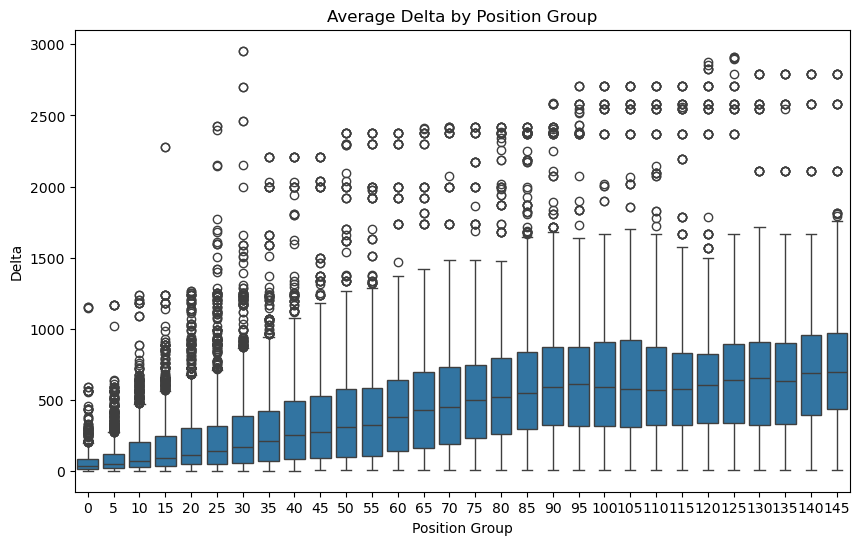

In [4]:
# Filter the data for the first 10 positions and non-zero delta values
filtered_df = simple_df[(simple_df['position'] < 150) & (simple_df['delta'] != 0) & (simple_df['delta'] < MAX_DELTA) & (simple_df['delta'] > MIN_DELTA)]

# Filter the data for races that are within a given length range
length_range = (250000, 2500000)  # Example length range in meters
filtered_df = filtered_df[(filtered_df['length'] >= length_range[0]) & (filtered_df['length'] <= length_range[1])]

# Create a new column 'position_group' that groups positions in intervals of 5
filtered_df['position_group'] = (filtered_df['position'] // 5) * 5

# Plot the box plot for the average delta by position group
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='position_group', y='delta')
plt.title('Average Delta by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Delta')
plt.show()

**What does this plot tell us, right now? Can we get a clearer picture? How?**

We need to remove negative values, too big values, and also, there is a more tricky problem... how many people can arrive at the same time (if we are measuring intervals of 1 second probably a bunch) for sure not 100, we need to understand what is a reasonable group size in order to avoid considering akwardly big groups in future analysis.

Another problem is: how small should be the delta like reasonably can someone arrive 3 hours later than the first person? probably yes in very long races, but probably not in shorter races, this means we should do different analysis based on teh different length.

## Consistency checks on `delta`

Some insights on how the delta is distributed, what are the problems with this column and how to address them can be given by checking some assumptions, analizing the values directly (using [procyclingstats](https://www.procyclingstats.com/) as a trusted source) and see why such assumptions don't hold.

### Zero `delta`s

`delta` seems to be set everywhere. Is it true or is it just all zeros?

In [5]:
tot_zero_delta = races_df[(races_df['position'] > 0) & (races_df['delta'] == 0)].shape[0]
print('Number of records with position > 0 and delta = 0', tot_zero_delta)
print(f'Percentage of times delta was 0, but the position is greater than 0: {tot_zero_delta / races_df.shape[0] * 100:.2f}%')

Number of records with position > 0 and delta = 0 115265
Percentage of times delta was 0, but the position is greater than 0: 19.54%


All those zeros are explained by the fact that when cyclists cross the finish line in groups, the same time is given to all of them, even though they arrive at a different order. It is not uncommon that even to hundreds of cyclists the same `delta` is given.

So the zero `delta`s for positions greater than zero is not a problem, not an error in the data.

### Monotonicity of `delta`

For how `delta` is defined, it should be monotonically increasing. That is $\mathtt{position}_i > \mathtt{position}_j\implies\mathtt{delta}_i\ge\mathtt{delta}_j$. Let's check if this is the case. Where it's not, we have problems that need to be studied and addressed.

In [6]:
stages_monotonic_delta = races_df.groupby('_url')['delta'].apply(lambda delta_series: delta_series.is_monotonic_increasing)

In [7]:
urls_stages_non_monotonic_delta = [stage_url for stage_url, truth in stages_monotonic_delta.items() if not truth]
#urls_stages_non_monotonic_delta

In [8]:
print(f"Out of {len(races_df['_url'].unique())} unique races, {len(urls_stages_non_monotonic_delta)}\
 don't have the values of delta in ascending order (as one would expect).")

Out of 5281 unique races, 346 don't have the values of delta in ascending order (as one would expect).


Non-monotonicity of the `delta` could be an error in the data that might lead to problems in the analysis.

The problem might be due to the way data was collected, but maybe it reveals something about the "phenomenon" that wasn't "captured" in the previous explaination of what `delta` is.

All in all, we should investigate further, and we do so by comparing our data from data available in [procyclingstats](https://www.procyclingstats.com/).

**NOTE**: The code in the following cell is slow to run.

In [9]:
from utility.data_understanding import delta_computer#, convert_date_seconds

non_matching_races = []
delta_due_to_extra_cyclists = []

for indice, race_url in enumerate(urls_stages_non_monotonic_delta):
    lista = pcs.Stage(f"race/{race_url}").results('rider_url', 'time')

    sub_df = races_df[races_df['_url'] == race_url]
    pcs_riders = [dizio['rider_url'].split('/')[1] for dizio in lista]

    # pcs list also includes disqualified people etc. Maybe the way I get the cyclists
    # that are also in the df is inefficient, but I don't care
    pcs_riders_also_in_df = [rider for rider in pcs_riders if rider in list(sub_df['cyclist'])]
    deltas_pcs_seconds =[delta_computer(rider_url, lista, in_date_format=False) for rider_url in pcs_riders_also_in_df]

    # This mess right here is necessary because in the dataframe, in some stages
    # there appear some cyclists that are not in pcs. This is highly sus...
    df_riders_also_in_pcs = [cyclist for cyclist in sub_df['cyclist'] if cyclist in pcs_riders]

    # We can compare only the the deltas for cyclists that appear both in pcs and in
    # the dataframe
    deltas_df_seconds = sub_df.loc[sub_df['cyclist'].isin(df_riders_also_in_pcs), 'delta']

    # Further problem: sometimes cyclists are listed twice on pcs, because they're disqualified or something
    if not all(deltas_df_seconds == deltas_pcs_seconds[:len(deltas_df_seconds)]):
        non_matching_races.append(race_url)
    if deltas_df_seconds.is_monotonic_increasing:
        delta_due_to_extra_cyclists.append(race_url)

In [10]:
print("For the following races, the delta values given by procyclingstats\
 and those present in the dataframe don't match:")
print('\n'.join(non_matching_races))

For the following races, the delta values given by procyclingstats and those present in the dataframe don't match:
giro-d-italia/2008/stage-19
gp-quebec/2011/result
paris-nice/2000/stage-5
tirreno-adriatico/2015/stage-2
tour-de-france/1995/stage-15
vuelta-a-espana/1993/stage-11


Since they're very few, these races were analized individually, and the following was discovered:
- We specifically asked Setzu about stage 19 of the Giro d'Italia 2008. Both the times in the dataset and those in ProCyclingStats are absurd. That race can safely be ignored, because something weird happened
- In the 2011's GP of Quebec it is only one `delta` which is different, and is Mr. Simone Ponzi, with a `delta` value of 25223 seconds. Clearly an outlier. Mr. Ponzi is present both in the dataset and in ProCyclingStats, with the same position, but the `delta` is different
- For the 5th stage of the Paris-Nice of 2011, there are some entries that are just different. It might be that the data in the dataframe has been recorded badly. In fact:
    - For some indices, the values match
    - There are some 903 (consistent with ProCyclingStats), and after that a very suspicious 93
    - The `delta`s in ProCyclingStats are monotonically increasing, those in the dataframe aren't
- For this race the problem is that two times are not recorded in ProCyclingStats, and it looks like this disaligned everything, in the dataframe, with respect to the website. Mr. Moreno Moser and Mr. Carlos Bentancur don't have their times in ProCyclingStats, but have one in the dataframe. The values are all disaligned, but those of ProCyclingStats look correct. It looks like there's an error in the dataframe, in which one could look more in detail
- The problem with the 15th stage of 1995's Tour de France is that Mr. Arsenio Gonzalez is recorded twice, both in the dataframe and in ProCyclingStats. The recorded `delta`s are consistent, is just the function that was set up above that does something weird (maybe because it treats duplicates badly). This is an error for sure, but at least both sources are consistently wrong
- In the Stage 11 of the 1993 Vuelta a difference is detected because Mr. Ignacio Garcia appears twice both in the dataset and in ProCyclingStats. This messes up the functions above, and in particular the `delta_computer`.

Some important takeaway points from this are:
- Some races can be (more or less) excluded, at least from the `delta`-related analysis
- Some cyclists appear multiple times in the leaderboard (see the *trollino* later), with different times and positions. Sometimes they appear twice only in the dataset, sometimes they appear twice also in the website. This might be due to disqualification "a posteriori".
- There are some insane `delta`s both in the dataframe and in the website. SOmtimes they have equal values, sometimes not but are both insane

We also kept track of the races which have monotonically increasing `delta` values, once the cyclist that - according to procyclingstats - never participated are removed. Maybe the non-monotonicity is due to the "errors" in the dataset uniquely, and the data in ProCyclingStats is consistent.

In [11]:
delta_due_to_extra_cyclists

['vuelta-a-espana/1983/stage-14']

By manually inspecting the dataframe and the data in ProCyclingStats, it turned out that, according to the website, Eric Vanderaerden never participated to the 14th stage of the Vuelta.

We thought that maybe the non-monotonicity of the deltas in our dataset was only due to these "outliers", but it's not the case. In fact, this race is the only one which gains the monotonicity property of the delta once we remove the riders that aren't there according to procyclingstats.

In [12]:
races_df.loc[107875:107877]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
107875,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:29:46,68,eric-vanderaerden,21.0,True,False,False,lotto-super-club-1991,1183.0
107876,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:39:46,69,eric-vanderaerden,21.0,True,False,False,lotto-super-club-1991,1783.0
107877,vuelta-a-espana/1983/stage-14,Vuelta a España,80.0,NaN,185000.0,NaN,NaN,705,NaN,1983-05-03 05:29:46,70,carlos-machin,25.0,True,False,False,NaN,1183.0


### Non-negativity of the `delta`

To be meaningful, `delta` should take non-negative values

In [13]:
races_df[races_df['delta']<0]['_url'].unique()

array(['vuelta-a-espana/1992/stage-19', 'paris-nice/1990/stage-7a',
       'tour-de-france/2003/stage-12', 'tour-de-suisse/1993/stage-4'],
      dtype=object)

Again, since it's just these three races we can investigate them one by one by looking at the website, and/or using the `pcs` library scrapers.

Of course the negative values must be excluded from any `delta` related analysis, but it's also helpful to gain some insight as to why those negative values are there. 

Here's what happened:
- In the 2003 Tour de France, Mr. Leonardo Bertagnolli was listed with a negative `delta` value also on ProCyclingStats. His position's number is crossed out in every stage of that race, as he withdrew from that tournament at the 15th stage. In fact homie right here doped himself, so all his achievements between January 1 2003 and May 18 2011 were taken away from him (source [Wikipedia](https://en.wikipedia.org/wiki/Leonardo_Bertagnolli)), including - therefore - this achievement
- Stage 19 of 1992's Vuelta de Espana is quite messed up overall
- ProCyclingStats data of stage 7a of 1990's Paris-Nice are weird... Apart from the first time, all the other look like trye times but with the flipped sign. Furthermore the values in ProCyclingStats are completely different from those in our dataset, in the `date` column. I can't figure out how the values in the dataset might have been gotten...
- The data that ProCyclingStats returns for the 4th stage of 1993's Tour de Suisse don't make sense. The first runner up should have covered 212 Km in two minutes... And these values are also in our dataset! Our dataset's situation is less severe in the sense that at least there are less negative `delta`s. This stage has to be deleted.

### Takeaway points

The analysis we just conducted was very fine-grained. Maybe too much. Let's summarize what we've learned, and some general patterns that we've extracted.

#### 1. Delta sometimes is not (weakly) monotonically increasing

For 346 races in the dataset, the `delta` values do not increase monotonically. For all of them except 6 the problem is also in ProCyclingStats, since the `delta` values match. Those 6 races have been discussed in greater detail above. <br>
For only one of the 346 races the problem goes away once we remove a cyclist that is in the dataset but not in ProCyclingStats data.

#### 2. Some races can be excluded

Some stages, such as the 4th stage of 1993's Tour de Suisse, or the 19th Stage of the 2008's Giro di Italia, can be excluded from any `delta`-related analysis because they're just wrong, or simply have too many problems.

In [14]:
races_df.loc[races_df['_url'] == 'tour-de-suisse/1993/stage-4', ['_url','length','date','position','cyclist','delta']]

,_url,length,date,position,cyclist,delta
520734,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:02:25,0,pavel-tonkov,0.0
520735,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:00:39,1,marco-saligari,-106.0
520736,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:03:23,2,zenon-jaskula,58.0
520737,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:02:44,3,fabio-casartelli,19.0
520738,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:02:44,4,beat-zberg,19.0
520739,tour-de-suisse/1993/stage-4,212300.0,1993-06-18 00:02:44,5,gerd-audehem,19.0


In general, all the races without monotonically increasing deltas and all races with negative deltas should be excluded. The more detailed analysis made above allows us to recover something, so that not too much is thrown away.

#### 3. Some cyclists appear multiple times in the leaderboard

Some cyclists appear twice in the leaderboard, of course with different `position` and `delta` values.

Sometimes they're repeated in the dataset but not in ProCyclingStats, such as our favourite "trollino", Riccardo Forconi

In [15]:
simple_df[simple_df['_url'] == 'itzulia-basque-country/2001/stage-5b'][-4:]

,_url,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,is_tarmac,delta
375864,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:17:58,118,massimo-podenzana,True,185.0
375865,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:18:05,119,kai-hundertmarck,True,192.0
375866,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:18:19,120,riccardo-forconi,True,206.0
375867,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 17:20:40,121,riccardo-forconi,True,61547.0


In [16]:
lista = pcs.Stage("race/itzulia-basque-country/2001/stage-5b").results('rider_url','time','status')
print("From ProCyclingStats (scraped from the website):")
for diz in lista:
    if diz['rider_url'] == 'rider/riccardo-forconi':
        print(f"Cyclist: {diz['rider_url'].split('/')[1]}, time: {diz['time']}, status: {diz['status']}, delta: {delta_computer('riccardo-forconi',lista,in_date_format=False)}")

From ProCyclingStats (scraped from the website):
Cyclist: riccardo-forconi, time: 0:18:19, status: DF, delta: 206


Sometimes they're present both in ProCyclingStats and in the dataset, like Arsenio Gonzalez, another "trollino"

In [17]:
races_df[races_df['_url'] == 'tour-de-france/1995/stage-15'].iloc[18:25]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
302534,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:30:40,18,arsenio-gonzalez,35.0,True,False,False,NaN,592.0
302535,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:30:40,19,bruno-cenghialta,33.0,True,False,False,bankgiroloterij-batavus-2000,592.0
302536,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:30:13,20,laurent-dufaux,26.0,True,False,False,linea-md-italia-maggi-mobili-1985,565.0
302537,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:30:13,21,oscar-pellicioli,30.0,True,False,False,NaN,565.0
302538,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:30:13,22,laudelino-cubino,32.0,True,False,False,sport-vlaanderen-baloise-2021,565.0
302539,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:34:02,23,carmelo-miranda,26.0,True,False,False,NaN,794.0
302540,tour-de-france/1995/stage-15,Tour de France,100.0,NaN,207000.0,6000.0,5.0,1871,NaN,1995-07-18 06:34:02,24,arsenio-gonzalez,35.0,True,False,False,NaN,794.0


In [18]:
lista = pcs.Stage("race/tour-de-france/1995/stage-15").results('rider_url','time','status')
print("From ProCyclingStats (scraped from the website):")
for diz in lista:
    if diz['rider_url'] == 'rider/arsenio-gonzalez':
        print(f"Cyclist: {diz['rider_url'].split('/')[1]}, time: {diz['time']}, status: {diz['status']}, delta: {delta_computer('arsenio-gonzalez',lista,in_date_format=False)}")
        # The second delta is wrong because the function just looks for Arsenio Gonzalez in the list and returns the first one

From ProCyclingStats (scraped from the website):
Cyclist: arsenio-gonzalez, time: 6:30:40, status: DF, delta: 592
Cyclist: arsenio-gonzalez, time: 6:34:02, status: DF, delta: 592


In any case, duplicate cyclists is an error. The fact that ProCyclingStats does it doesn't make it right. The causes for this error are unknown to us.

Removing the duplicate row is the right thing to do regardless, we just have to keep in mind that in some cases ProCyclingStats won't offer guidance for which record is the one to keep. So in removing the row there is the chance that we're introducing some mistakes.

#### 4. Negative deltas aren't just a problem of the dataset

The negative deltas are also a problem that is present in ProCyclingStats, which is an authoritative source. This means that is not only a problem of how the data was collected in the database, but also of how the data was recorded.

The negative deltas are present in very few races, and the problem of the negative deltas takes very different forms, not traceable to a single, identifiable and evident cause.

#### 5. Wrap up of the wrap up

Let's create a dataframe in which all the problems above are addressed. So that they don't remain words, but are code instead.

In [19]:
races_df_copy = races_df.copy()

fixed_races = []

In [20]:
def are_problem_fixed(url:str) -> bool:
    # Are now the deltas ordered?
    c1 = races_df_copy[races_df_copy['_url'] == url]['delta'].is_monotonic_increasing
    # Are now the deltas nonnegative?
    c2 = np.all(races_df_copy[races_df_copy['_url'] == url]['delta'] >= 0)
    return c1 and c2

In [22]:
# Remove Leonardo Bertagnolli from Stage 12 of 2003 Tour de France
races_df_copy = races_df_copy[
        ~(races_df_copy['cyclist'] == 'leonardo-bertagnolli') | 
        ~(races_df_copy['_url'] == 'tour-de-france/2003/stage-12')
    ]
if are_problem_fixed('tour-de-france/2003/stage-12'):
    fixed_races.append('tour-de-france/2003/stage-12')

# Remove Simone Ponzi from GP Quebec of 2011
races_df_copy = races_df_copy[
        ~(races_df_copy['cyclist'] == 'simone-ponzi') | 
        ~(races_df_copy['_url'] == 'gp-quebec/2011/result')
    ]
if are_problem_fixed('gp-quebec/2011/result'):
    fixed_races.append('gp-quebec/2011/result')

# Remove Moreno Moser and Carlos Bentancur from Stage 2 of 2015 Tirreno-Adriatico
races_df_copy = races_df_copy[
        ~(
            (races_df_copy['cyclist'] == 'moreno-moser') | 
            (races_df_copy['cyclist'] == 'carlos-betancur')
         ) | 
        ~(races_df_copy['_url'] == 'tirreno-adriatico/2015/stage-2')
    ]
if are_problem_fixed('tirreno-adriatico/2015/stage-2'):
    fixed_races.append('tirreno-adriatico/2015/stage-2')

# Remove the duplicate result for Arsenio Gonzalez from Stage 15 of 1995's Tour de France
races_df_copy.drop([302540], inplace=True)
if are_problem_fixed('tour-de-france/1995/stage-15'):
    fixed_races.append('tour-de-france/1995/stage-15')

# Remove the duplicate result for Ignacio Garcia from Stage 11 of 1993's Vuelta a Espana
races_df_copy.drop([492194], inplace=True)
if are_problem_fixed('vuelta-a-espana/1993/stage-11'):
    fixed_races.append('vuelta-a-espana/1993/stage-11')

# Remove Eric Vanderaerden from Stage 14 of 1983's Vuelta a Espana
races_df_copy = races_df_copy[
        ~(races_df_copy['cyclist'] == 'eric-vanderaerden') | 
        ~(races_df_copy['_url'] == 'vuelta-a-espana/1983/stage-14')
    ]
if are_problem_fixed('vuelta-a-espana/1983/stage-14'):
    fixed_races.append('vuelta-a-espana/1983/stage-14')



In [23]:
urls_guilty = np.unique(np.concatenate([urls_stages_non_monotonic_delta, races_df[races_df['delta']<0]['_url'].unique()]))
urls_races_to_drop = [url for url in urls_guilty if url not in fixed_races]

In [24]:
races_df_copy = races_df_copy[~races_df_copy['_url'].isin(urls_races_to_drop)]

## Visualize the delta values

As already said, after some researches in Setzu office we discovered that it is really common that even 150 cyclists or more arrive together. For this reason the final decision on this is that it's reasonable that even 200 cyclist arrive at the same time. Moreover we see that this phenomenon is unusual, as expected.

We shall refer to a *group* as a set of cyclists that have contiguous `position` values and that have the same `delta` value.

In [25]:
# we are going to do things in a for loop, this will probably be a bit slow, but it is not my fault, it is python's fault
groups = []#this will contain (race_id, group_delta, group_size)
for index, row in simple_df.iterrows():
    # first of all we create a list of the "groups" length 
    if len(groups) == 0:
        groups.append((row['_url'], row['delta'], 1))
    else:
        if groups[-1][1] == row['delta'] and groups[-1][0] == row['_url']:
            groups[-1] = (row['_url'], row['delta'], groups[-1][2] + 1)
        else:
            groups.append((row['_url'], row['delta'], 1))            
print('Groups:', groups[0:4])

Groups: [('tour-de-france/1978/stage-6', 0.0, 5), ('tour-de-france/1978/stage-6', 27.0, 100), ('tour-de-france/1978/stage-6', 64.0, 1), ('vuelta-a-espana/2016/stage-14', 0.0, 1)]


Given the plot below the group sizes seem reasonable as they are

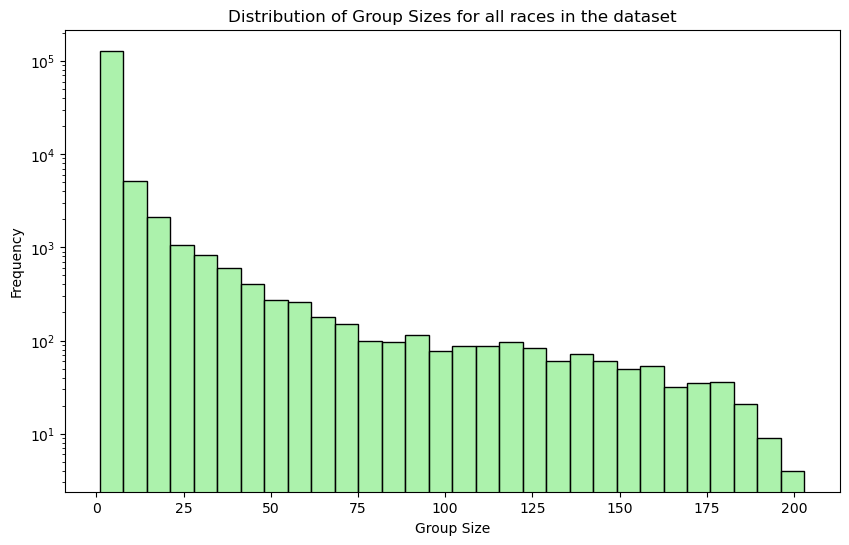

In [26]:
# Extract group sizes
group_sizes = [group[2] for group in groups]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.histplot(group_sizes, bins=30, kde=False, color='lightgreen')
plt.title('Distribution of Group Sizes for all races in the dataset')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

but... the delta itself can have some problems...

let's have a look to the distribution if we don't touch the `delta` column.

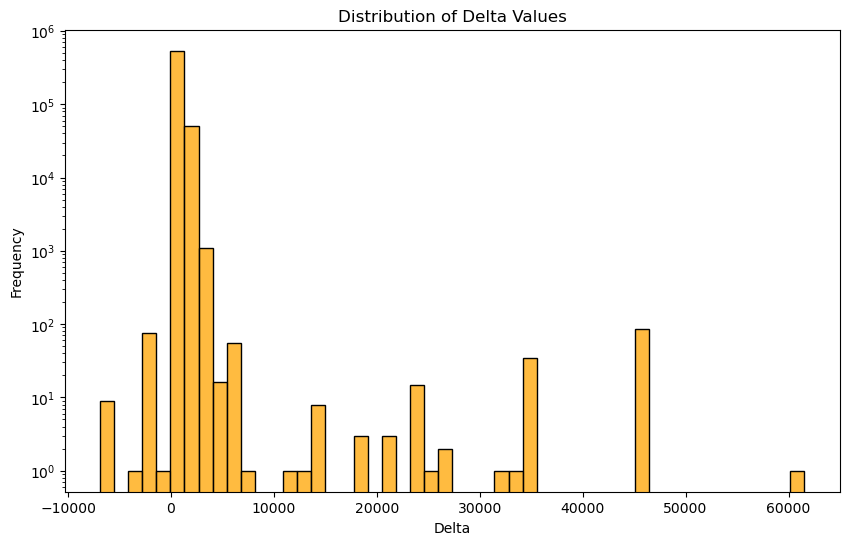

In [27]:
# Plot the distribution of delta values
plt.figure(figsize=(10, 6))
sns.histplot(simple_df['delta'], bins=50, kde=False, color='orange')
plt.title('Distribution of Delta Values')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

It's horrific! There are negative delta values (as it was noticed also during the assessment phase), and there are even `delta` values that are over 30000 seconds. That's over 8 hours.

## Delta values after processing

Let's try to see what happens when we address some of the problems that we found in the data quality assessment phase. That is, if we use the dataset in which some stages are removed (as identified in the previous phase).

### Comparison of `delta` values distributions

Let's compare the distribution of the `delta` values with the distribution that we'd get if we removed all the duplicated cyclists that appear in a stage (we noticed this phenomenon in the consistency check phase).

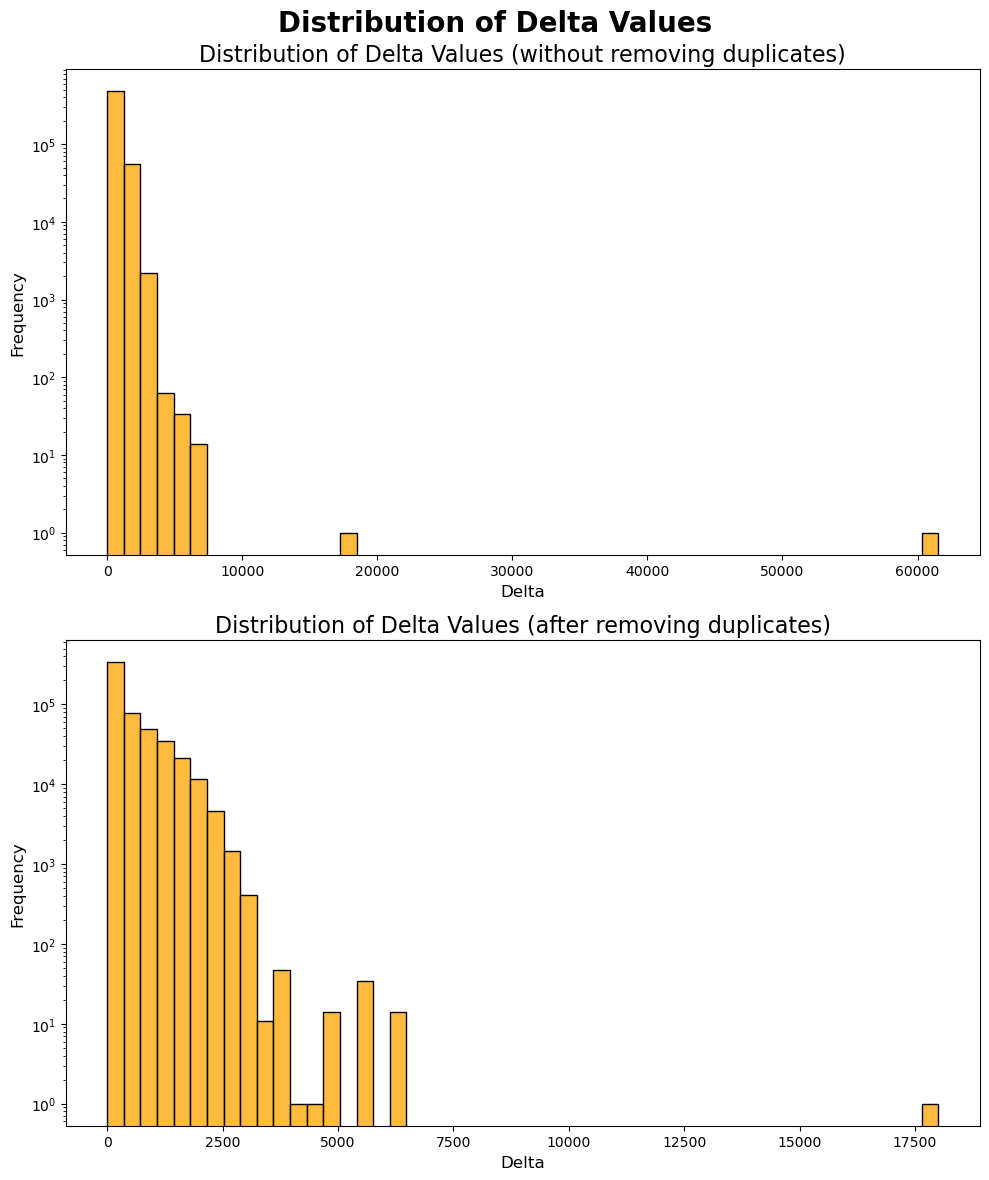

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle('Distribution of Delta Values', fontsize=20, fontweight='bold')

sns.histplot(races_df_copy['delta'], bins=50, kde=False, color='orange', ax=ax[0])
ax[0].set_title('Distribution of Delta Values (without removing duplicates)', fontsize=16)
ax[0].set_xlabel('Delta', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_yscale('log')

sns.histplot(races_df_copy.drop_duplicates(subset=['_url', 'cyclist'], keep='first')['delta'], bins=50, kde=False, color='orange', ax=ax[1])
ax[1].set_title('Distribution of Delta Values (after removing duplicates)', fontsize=16)
ax[1].set_xlabel('Delta', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()

... Most of the problems disappeared! Just two `delta` values are out of distribution now! This is great news, because it means that we can trace back to what it is that caused the problems instead of just throwing away number.

In fact, we threw away some races for a reason, and we analized in depth where the difference lied with respect to another source (ProCyclingStats).

Moreover, if we remove the duplicated cyclists, the `delta` values out of distribution is just one.

Even though - as already noticed - removing the duplicates by keeping only the 1st one may introduce some inexactness, it looks like a winning move.

In [35]:
races_df_copy[races_df_copy['delta'] > 17000]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
26891,tour-de-suisse/2001/stage-1,Tour de Suisse,50.0,NaN,178800.0,NaN,NaN,873,NaN,2001-06-20 09:26:55,134,yvon-ledanois,32.0,True,False,False,NaN,18006.0
375867,itzulia-basque-country/2001/stage-5b,Vuelta al País Vasco,50.0,NaN,10000.0,NaN,NaN,898,NaN,2001-04-14 17:20:40,121,riccardo-forconi,31.0,True,False,False,NaN,61547.0


Oh, look! Our *trollino* reappeared! Let's remove the duplicates, Without further ado!

In [59]:
races_df_copy.drop_duplicates(subset=['_url', 'cyclist'], keep='first', inplace=True)

Let's see the groups in the "cleaned up" dataset:

In [60]:
# we are going to do things in a for loop, this will probably be a bit slow, but it is not my fault, it is python's fault
groups_new = []#this will contain (race_id, group_delta, group_size)
for index, row in races_df_copy.iterrows():
    # first of all we create a list of the "groups" length 
    if len(groups_new) == 0:
        groups_new.append((row['_url'], row['delta'], 1))
    else:
        if groups_new[-1][1] == row['delta'] and groups_new[-1][0] == row['_url']:
            groups_new[-1] = (row['_url'], row['delta'], groups_new[-1][2] + 1)
        else:
            groups_new.append((row['_url'], row['delta'], 1))            
print('Groups:', groups_new[0:4])

Groups: [('tour-de-france/1978/stage-6', 0.0, 5), ('tour-de-france/1978/stage-6', 27.0, 100), ('tour-de-france/1978/stage-6', 64.0, 1), ('vuelta-a-espana/2016/stage-14', 0.0, 1)]


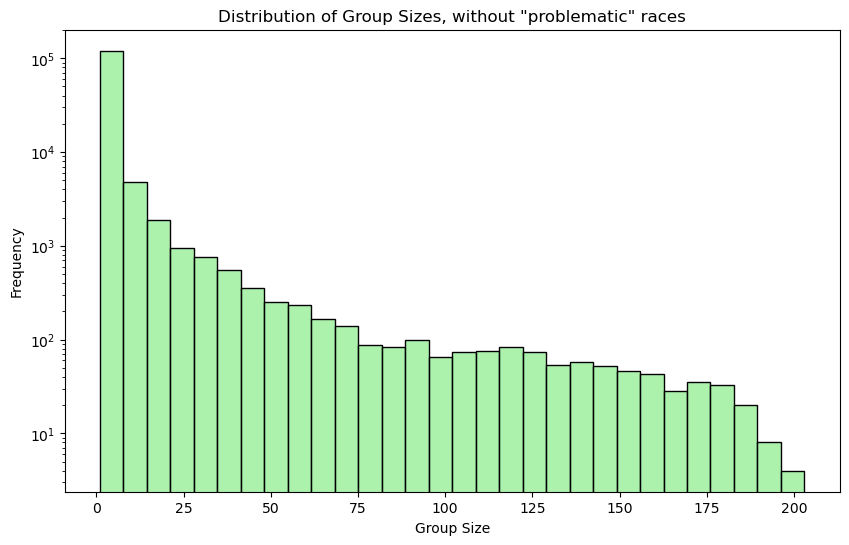

In [61]:
# Extract group sizes
group_sizes_new = [group[2] for group in groups_new]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.histplot(group_sizes_new, bins=30, kde=False, color='lightgreen')
plt.title('Distribution of Group Sizes, without "problematic" races')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

This distribution almost looks identical to the one we had before.

### Values of `delta` for different `length` values

Let's start with the distribution of `delta` at different values for `length`.

In [63]:
# We manually set the extrema of the length intervals in which we subdivide the length
# These intervals were chosen based on the analysis of the distribution of the length values vs the stage_type
LENGHT_CHECKPOINTS = [0, 50000, 100000, 183000, races_df['length'].max()]

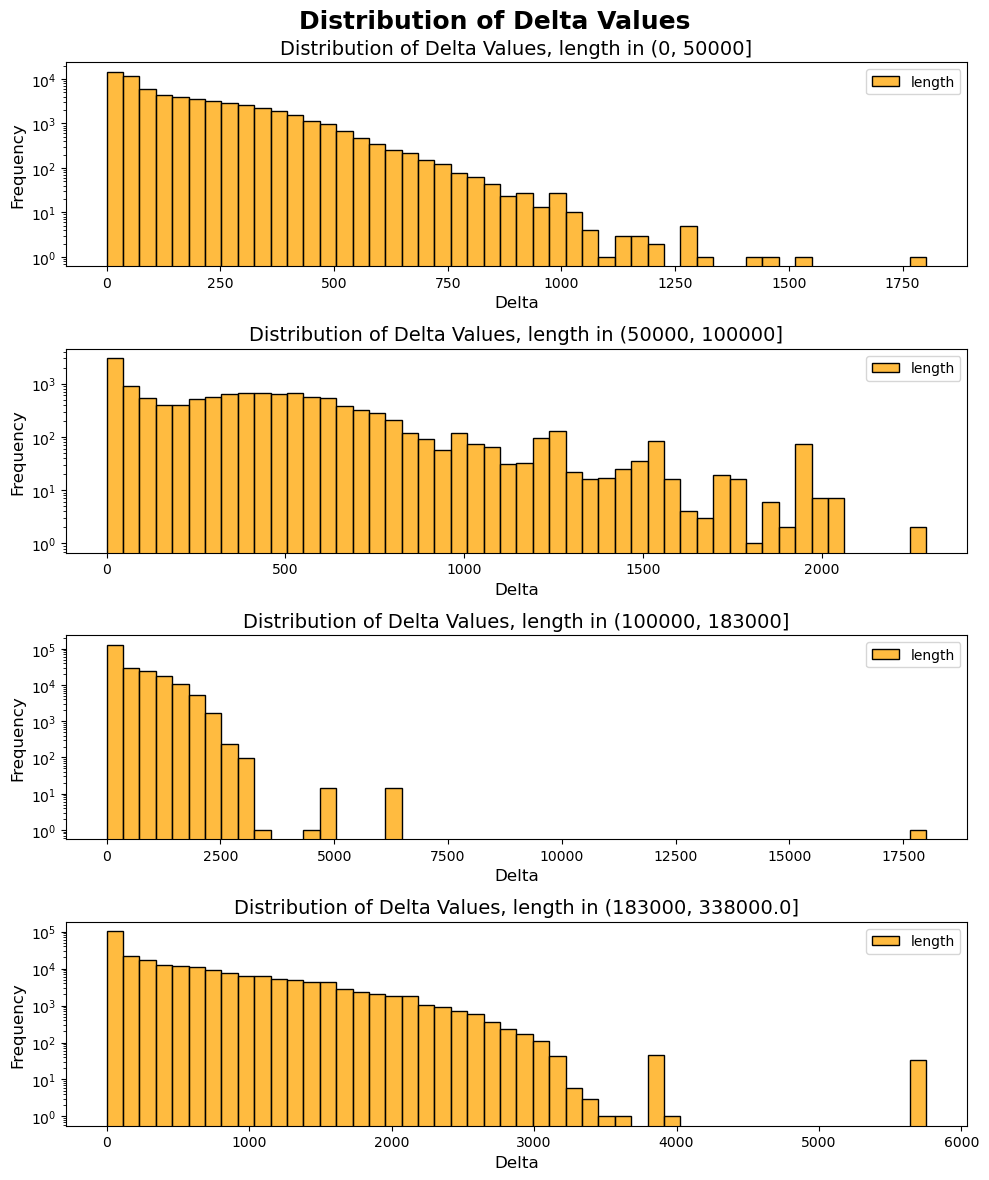

In [65]:
fig, ax = plt.subplots(len(LENGHT_CHECKPOINTS) - 1, 1, figsize=(10, 12))
fig.suptitle('Distribution of Delta Values', fontsize=18, fontweight='bold')

for i, (start, end) in enumerate(zip(LENGHT_CHECKPOINTS[:-1], LENGHT_CHECKPOINTS[1:])):
    sub_df = races_df_copy[(races_df_copy['length'] > start) & (races_df_copy['length'] <= end)]

    sns.histplot(sub_df['delta'], bins=50, kde=False, color='orange', ax=ax[i], label='length')
    ax[i].set_title(f'Distribution of Delta Values, length in ({start}, {end}]', fontsize=14)
    ax[i].set_xlabel('Delta', fontsize=12)
    ax[i].set_ylabel('Frequency', fontsize=12)
    ax[i].set_yscale('log')
    ax[i].legend()

plt.tight_layout()
plt.show()

**TODO**: Qualche commento su questo

From the data understanding part (in particular where we examined the distribution of `length` values for different `stage_types`), we know where **FINIRE** voglio dire che sappiamo quanto sono lunghe le ITT e le RR.

**TODO** I want something crazy: a 3D Plot, for the joint distribution of `delta` and `length`! Let me dream!

### Delta values for different `stage_type`s

---

looks like, someone (riccardo-forconi) arrived twice, and that the second time he arrived after 17h. Now, I'm no professional cyclist, but I think this is wrong, and there are many duplicate, to solve this problem we will remove time that don't make much sense and, if there are still duplicates we will keep the first instance.

We cut at 20000 seconds of delta that is about 5,5h in some very long races it is maybe reasonable to arrive with 5/6 hours of delay, but there are very few instances of these, if someone has higher delta though, they are probably wrong records

In [31]:
# Remove rows where delta is greater than 20000
filtered_df = simple_df[simple_df['delta'] <= 20000]
# remove rows where delta is less than -0
filtered_df = filtered_df[filtered_df['delta'] >= 0]
# Remove cyclists that arrived twice in the same race, keeping the first occurrence
filtered_df = filtered_df.drop_duplicates(subset=['_url', 'cyclist'], keep='first')

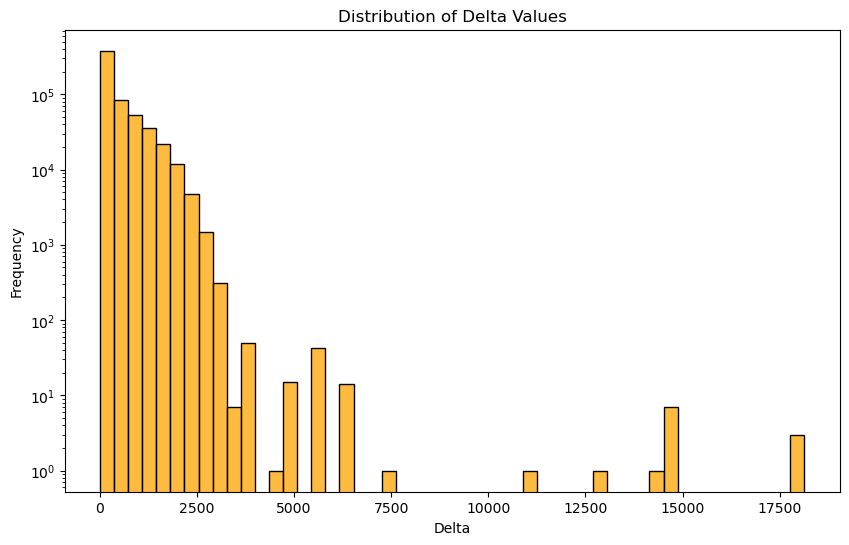

In [32]:
# plot the updated histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['delta'], bins=50, kde=False, color='orange')
plt.title('Distribution of Delta Values')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

***TODO***: To remove more instances is possible, given that after 5000 they are really rare, but we have no way of checking if these numbers are correct. This will be discussed with the team. (The plot look better if we cut at 3000)

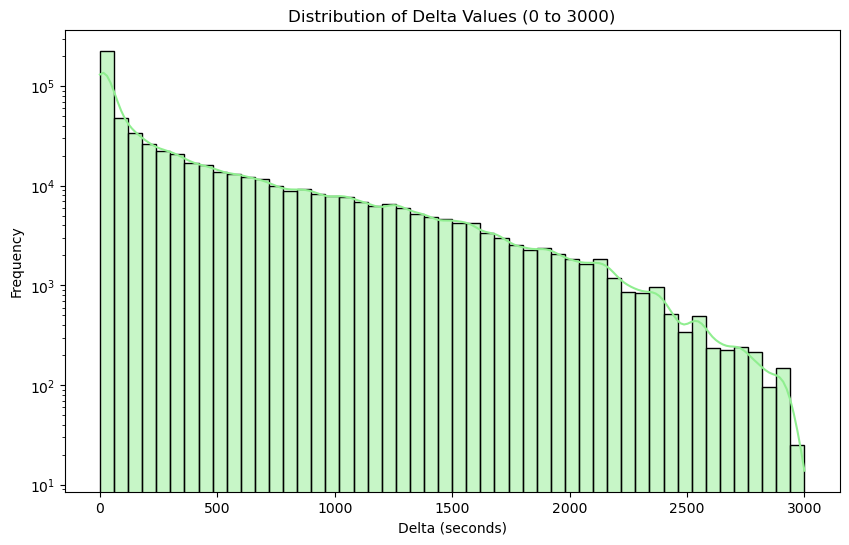

In [33]:
DELTA_MAX = 3000
# Filter the data for delta values in the range 0 to DELTA_MAX
filtered_delta_df = filtered_df[(filtered_df['delta'] <= DELTA_MAX)]

# Plot the histogram for the filtered delta values
plt.figure(figsize=(10, 6))
sns.histplot(filtered_delta_df['delta'], bins=50, kde=True, color='lightgreen')
plt.title(f'Distribution of Delta Values (0 to {DELTA_MAX})')
plt.xlabel('Delta (seconds)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

the further analysis done in the old version of this notebook is to be considered outdated 